# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 12.01

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [4]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: predict_proba возвращает вероятности пренадлежности какому-то классу, а не сам класс

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [5]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

In [6]:
import warnings

warnings.filterwarnings('ignore')

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


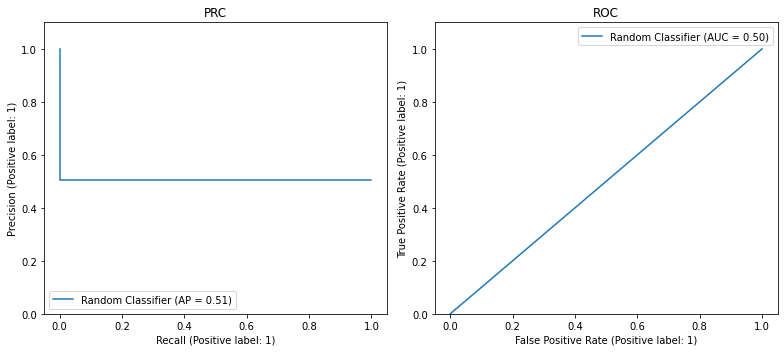

In [7]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [8]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [9]:
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV


auc_pr = make_scorer(average_precision_score, greater_is_better = True)
C = np.logspace(-6, 2, 10) 
param = {'C': C}
svc = LinearSVC(max_iter=100000)
svc_grid = GridSearchCV(svc,param_grid = param, scoring = auc_pr, cv=5)

svc_grid.fit(X_train, y_train)

best_c = svc_grid.best_params_['C']
best_c

5.994842503189409e-05

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

Some Classifier metrics
AUC-PR: 0.83027
AUC-ROC: 0.84377


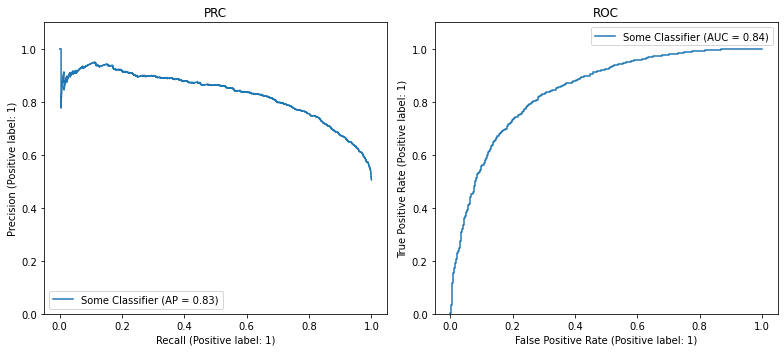

In [10]:
y_pred_1 = svc_grid.decision_function(X_test)
depict_pr_roc(y_test, y_pred_1)

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

Мои значения:

AUC-PR: 0.83027

AUC-ROC: 0.84377

Случайный классификатор:

AUC-PR: 0.75283

AUC-ROC: 0.50000

Моя модель лучше)

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=100000)
lr_grid = GridSearchCV(lr,param_grid = param, scoring = auc_pr, cv=5)

lr_grid.fit(X_train, y_train)

best_c_lr = lr_grid.best_params_['C']
best_c_lr

0.21544346900318823

Some Classifier metrics
AUC-PR: 0.82915
AUC-ROC: 0.84787


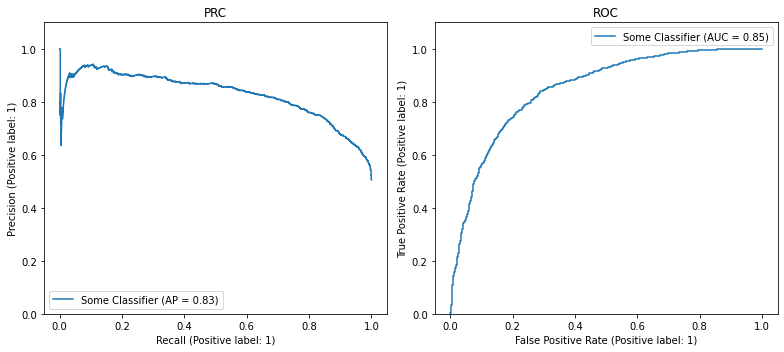

In [12]:
y_pred_lr = lr_grid.predict_proba(X_test)[:,1]
depict_pr_roc(y_test, y_pred_lr)

Значения для логистической регресии:

AUC-PR: 0.82915

AUC-ROC: 0.84787

Случайный классификатор:

AUC-PR: 0.75283

AUC-ROC: 0.50000

Логичстическая регресия лучше)

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

In [13]:
def all_depict_pr_roc(y_true, predictions, classifier_names):
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    for y_pred, classifier_name in zip(predictions, classifier_names):
        print(classifier_name, 'metrics')
        PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        print('AUC-PR: %.5f' % auc(recall, precision))

        RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
        print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))

    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()
    plt.show()

Random metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000
SVM metrics
AUC-PR: 0.83027
AUC-ROC: 0.84377
LR metrics
AUC-PR: 0.82915
AUC-ROC: 0.84787


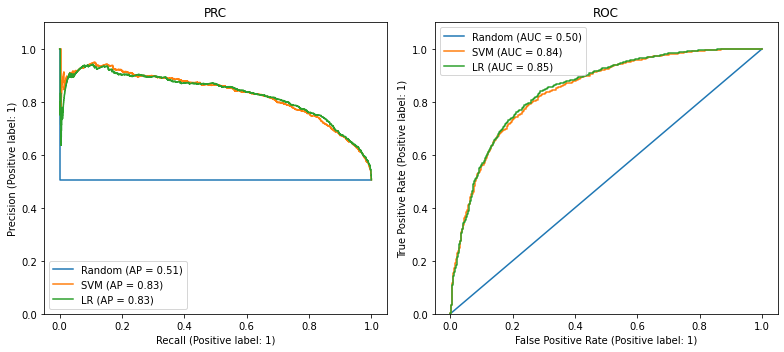

In [14]:
predict = [y_random, y_pred_1, y_pred_lr]
classifier_name = ['Random', 'SVM', 'LR']
all_depict_pr_roc(y_test, predict, classifier_name)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** AUC-PR лучше у SVM, в то время как AUC-ROC лучше у LR. AUC-ROC больше у LR, возможно из-за того, что у нас взаимосвзяь между объектами близка к линейной. Но вообще SVM должна давать лучшее значения, так как для SVM достаточно, чтобы отступ был больше 1, в то время как LR хочет сделать этот отступ максимальным. Поэтому SVM должно приводить к лучшим значения AUC-PR и AUC-ROC, а LR будет давать лучшие вероятности. Но как я уже говорил, все равно все зависит от взаимосвязи объектов

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [15]:
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
from sklearn.svm import SVC

svc = SVC(kernel='linear').fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
print('SVC ROC-AUC:', roc_auc_score(y_test, svc_pred))

SVC ROC-AUC: 0.9456302800375469


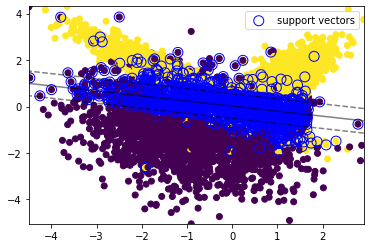

In [17]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(YY.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:,0], X[:,1], c=y)
                

    #Отрисовали опорные векторы
    if plot_support:
        sup_vec = model.support_vectors_
        plt.scatter(sup_vec[:,0], sup_vec[:,1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, svc)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Объекты, которые находятся между разделюящей и отступом. Чтобы расстояние от разделяющей прямой до объектов каждого класса было максимальным

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [18]:
lr_1 = LogisticRegression(max_iter=100000, C = best_c_lr).fit(X_train, y_train)


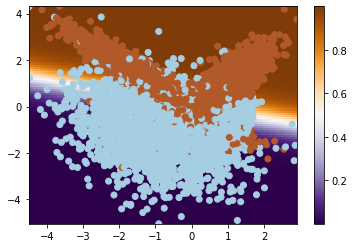

In [19]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]

    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:,0], X[:,1], c = y,
                cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, lr_1)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Она визуализирована в виде прямой, с отрицательным углом наклона. Здесь наша модель не уверена в том, какой именно это класс, поэтому здесь объекты как бы разделяют наши классы. В таких точках уравнение нашей модели приравниваются к 0, из-за чего возникает линия.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [20]:
def plot_calibration_curve(y_test, preds, model):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
#     plt.grid()
    
    plt.plot([0, 1], [0, 1], linestyle='--', label='Ideal Curve')

    plt.title(f'Calibration curve for {model}')
    plt.xlabel('Prob')
    plt.ylabel('Percentage of true')
    plt.legend()
    plt.grid()


Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [21]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
svc_2 = LinearSVC(max_iter=100000, C = best_c).fit(X_train, y_train)
y_pred_2 = svc_2.decision_function(X_test)
y_pred_2 = (y_pred_2 - y_pred_2.min()) / (y_pred_2.max() - y_pred_2.min())

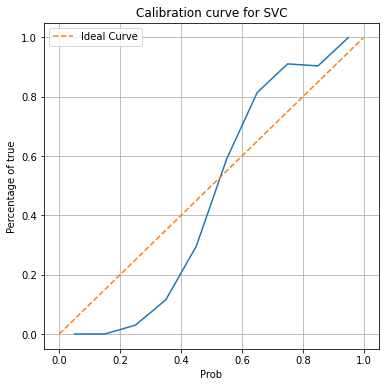

In [23]:
plot_calibration_curve(y_test, y_pred_2, 'SVC')

In [24]:
lr_2 = LogisticRegression(max_iter=100000, C = best_c_lr).fit(X_train, y_train)
y_pred_lr_2 = lr_2.predict_proba(X_test)[:,1]


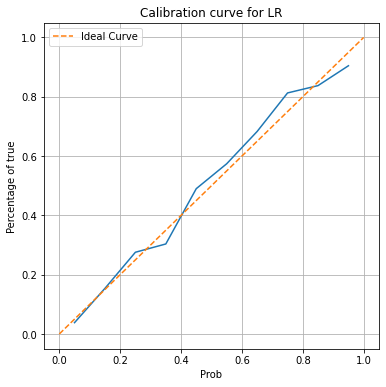

In [25]:
plot_calibration_curve(y_test, y_pred_lr_2, 'LR')

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** Кривая для LR хорошо откалибрована (линия идет почти по диагонали), так как она предсказывает вероятности. У SVM дела хуже, так как она старается просто отнести к какому-то классу

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

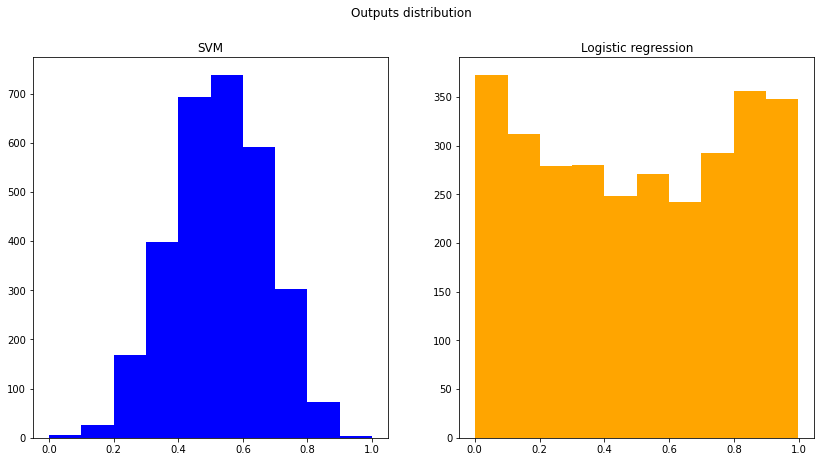

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(y_pred_2, color='blue')
axs[1].hist(y_pred_lr_2, color='orange')

axs[0].set_title('SVM')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** SVM не предсказывает вероятности, а просто относит их к какому-то классу, максимизируя отступ. Поэтому она примерно равномерно относит их к различным классам. Поэтому распределение похоже на нормальное. А LR выдает вероятности, поэтому где где она точно уверена, что класс 0 (-1), там вероятность маленькая, поэтому получается большое количество таких объектов. Аналогично с классом 1

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

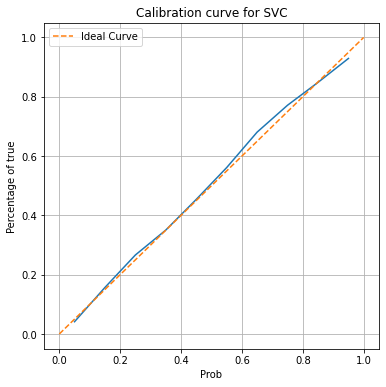

In [27]:
from sklearn.calibration import CalibratedClassifierCV
sigmoid_svc = CalibratedClassifierCV(svc_2, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, sigmoid_svc_pred, 'SVC')

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** Калибровочная кривая стала почти идеальной (проходит почти под 45 градусов)

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

Буду реализовывать калибровку Платта, подбирая А и С

In [28]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
svc_4 = LinearSVC(max_iter=100000, C = best_c).fit(X_train, y_train)
y_pred_4 = svc_4.decision_function(X_test)

In [30]:
A = -0.1 # просто подобрал)
C = -0.1 
lr = 0.01
for i in range(100000):
    pred = 1 / (1 + np.exp(A * y_pred_4 + C))
    grad_A = np.dot(y_pred_4, (pred - y_test)) / len(y_test)
    grad_C = np.sum(pred - y_test) / len(y_test)
    A += lr * grad_A
    C += lr * grad_C

print(f"A: {A}")
print(f"C: {C}")

A: -3.274299638170804
C: -0.23315295215093876


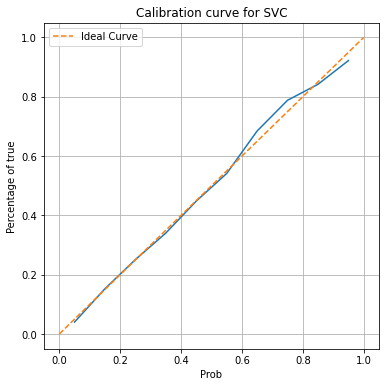

In [31]:
sig_svc = 1 / (1 + np.exp(A * y_pred_4 + C))

plot_calibration_curve(y_test, sig_svc, 'SVC')

Не как библиотечная, но тоже ничего)

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [56]:
df = pd.read_csv('/Users/timurkin/Downloads/archive/bike_buyers.csv')
#Заменим пропуски категориальных переменных
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region', 'Purchased Bike']
df[categorical] = df[categorical].fillna('undefined')
# df.isna().sum()
# df.dtypes

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

categoric = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']
numeric = ['Income', 'Children', 'Cars', 'Age']
# # #Разделим на категориальные признаки и числовые
X_numerical = X[numeric]
X_categorical = X[categoric]

В начале поработаем только с категориальными признаками

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [58]:
from sklearn.preprocessing import OrdinalEncoder
import time

t_st = time.time()

ordenc = OrdinalEncoder()
X_train = ordenc.fit_transform(X_train)
X_test = ordenc.transform(X_test)
lr_3 = LogisticRegression(max_iter=100000, C = best_c_lr).fit(X_train, y_train)
t_fin = time.time()
y_pred_lr_3 = lr_3.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_lr_3)
print('LR AUC-PR: %.5f' % auc(recall, precision))
print(f'TIME:{t_fin - t_st}')





LR AUC-PR: 0.57807
TIME:0.015326976776123047


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

In [60]:
from sklearn.preprocessing import OneHotEncoder

t_st = time.time()

hotenc = OneHotEncoder()
X_train = hotenc.fit_transform(X_train)
X_test = hotenc.transform(X_test)
lr_3 = LogisticRegression(max_iter=100000, C = best_c_lr).fit(X_train, y_train)
t_fin = time.time()
y_pred_lr_3 = lr_3.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_lr_3)
print('LR AUC-PR: %.5f' % auc(recall, precision))
print(f'TIME:{t_fin - t_st}')

LR AUC-PR: 0.66083
TIME:0.020191431045532227


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

In [62]:
t_st = time.time()
uniq_mean = {}

for col in X_train.columns:
    y_mean = y_train.groupby(X_train[col]).mean()
    uniq_mean[col] = y_mean
    X_train[col + 'mte'] = X_train[col].map(uniq_mean[col])
    X_train.drop(columns=[col], inplace=True)

for col in X_test.columns:
    X_test[col + 'mte'] = X_test[col].map(uniq_mean[col]).fillna(y_train.mean())
    X_test.drop(columns=[col], inplace=True)

lr_4 = LogisticRegression(max_iter=100000, C = best_c_lr).fit(X_train, y_train)
t_fin = time.time()
y_pred_lr_4 = lr_4.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_lr_4)
print('LR AUC-PR: %.5f' % auc(recall, precision))
print(f'TIME:{t_fin - t_st}')

LR AUC-PR: 0.65023
TIME:0.03448200225830078


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

In [64]:
from sklearn.base import BaseEstimator, TransformerMixin

class Mean_TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categoric_feaut):
        self.categoric_feaut = categoric_feaut
        self.uniq_mean = {}
    
    def fit(self, X, y):
        for feature in self.categoric_feaut:
            self.uniq_mean[feature] = y.groupby(X[feature]).mean()
        return self
    
    def transform(self, X, y=None):
        X_transform = X.copy()
        for feature in self.categoric_feaut:
            X_transform[feature] = X_transform[feature].map(self.uniq_mean[feature])
        return X_transform

t_st = time.time()

mte = Mean_TargetEncoder(categoric_feaut=categoric).fit(X_train, y_train)

X_train_mte = mte.transform(X_train, y_train)
X_test_mte = mte.transform(X_test, y_train)

lr_5 = LogisticRegression(max_iter=100000, C = best_c_lr).fit(X_train_mte, y_train)
t_fin = time.time()
y_pred_lr_5 = lr_5.predict_proba(X_test_mte)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_lr_5)
print('LR AUC-PR: %.5f' % auc(recall, precision))
print(f'TIME:{t_fin - t_st}')


LR AUC-PR: 0.65023
TIME:0.021928071975708008


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

class Mean_TargetEncoder_eps(BaseEstimator, TransformerMixin):
    def __init__(self, categoric_feaut):
        self.categoric_feaut = categoric_feaut
        self.uniq_mean = {}
    
    def fit(self, X, y):
        for feature in self.categoric_feaut:
            self.uniq_mean[feature] = y.groupby(X[feature]).mean()
        return self
    
    def transform(self, X, y=None):
        X_transform = X.copy()
        for feature in self.categoric_feaut:
            X_transform[feature] = X_transform[feature].map(self.uniq_mean[feature]) + np.random.normal(0, 0.01, size=X_transform.shape[0])
        return X_transform

t_st = time.time()

mte = Mean_TargetEncoder_eps(categoric_feaut=categoric).fit(X_train, y_train)

X_train_mte = mte.transform(X_train, y_train)
X_test_mte = mte.transform(X_test, y_train)

lr_5 = LogisticRegression(max_iter=100000, C = best_c_lr).fit(X_train_mte, y_train)
t_fin = time.time()
y_pred_lr_5 = lr_5.predict_proba(X_test_mte)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_lr_5)
print('LR AUC-PR: %.5f' % auc(recall, precision))
print(f'TIME:{t_fin - t_st}')

LR AUC-PR: 0.65649
TIME:0.021821260452270508


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Помогло, но не очень сильно, тут возникает сильный рандом). Каждый раз перезапуская ячейку значения меняются, что и очевидно, так как мы берем рандомные значения из нормального распределения. Еще сильно влияет матож и дисперсия

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




Так как у нас нет времени записи объекта в датасет, то первый способоб сделать нельзя. 

Буду делать второй способ, разбивая по фолдам 

In [76]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

class Mean_TargetEncoder_KFold(BaseEstimator, TransformerMixin):
    def __init__(self, categoric_feaut, n_splits=5):
        self.categoric_feaut = categoric_feaut
        self.n_splits = n_splits
        self.uniq_mean = {}
    
    def fit(self, X, y):
        kf = KFold(n_splits = self.n_splits)

        for feature in self.categoric_feaut:
            feat_val = []
            
            for i, (train_index, test_index) in enumerate(kf.split(X, y)):
                X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                y_means = y_train.groupby(X_train[feature]).mean()
                feat_val.append(y_means)

            self.uniq_mean[feature] = pd.concat(feat_val).groupby(level=0).mean()

        return self
    
    def transform(self, X, y=None):
        X_transform = X.copy()
        for feature in self.categoric_feaut:
            X_transform[feature] = X_transform[feature].map(self.uniq_mean[feature]) + np.random.normal(0, 0.01, size=X_transform.shape[0])
        return X_transform


t_st = time.time()

mte_kf = Mean_TargetEncoder_KFold(categoric_feaut=categoric).fit(X_train, y_train)

X_train_mte_kf = mte_kf.transform(X_train, y_train)
X_test_mte_kf = mte_kf.transform(X_test, y_train)

lr_6 = LogisticRegression(max_iter=100000, C = best_c_lr).fit(X_train_mte_kf, y_train)
t_fin = time.time()
y_pred_lr_6 = lr_6.predict_proba(X_test_mte_kf)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_lr_6)
print('LR AUC-PR: %.5f' % auc(recall, precision))
print(f'TIME:{t_fin - t_st}')

LR AUC-PR: 0.64136
TIME:0.05907607078552246


#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

class Mean_TargetEncoder_gl_mean(BaseEstimator, TransformerMixin):
    def __init__(self, categoric_feaut, C):
        self.categoric_feaut = categoric_feaut
        self.C = C
        self.uniq_mean = {}
        self.gl_mean = 0
    
    def fit(self, X, y):
        self.global_mean = y.mean()
        for feature in self.categoric_feaut:
            feature_cnt = X[feature].value_counts()
            feature_means = y.groupby(X[feature]).mean()
            self.uniq_mean[feature] = (feature_cnt * feature_means + self.C * self.global_mean) / (feature_cnt + self.C)
        return self
    
    def transform(self, X, y=None):
        X_transform = X.copy()
        for feature in self.categoric_feaut:
            X_transform[feature] = X_transform[feature].map(self.uniq_mean[feature])
            if y is not None:
                X_transform[feature].fillna(self.global_mean, inplace=True)
        return X_transform

t_st = time.time()

mte_gl_mean = Mean_TargetEncoder_gl_mean(categoric_feaut=categoric, C = 10).fit(X_train, y_train)

X_train_mte_gl_mean = mte_gl_mean.transform(X_train, y_train)
X_test_mte_gl_mean = mte_gl_mean.transform(X_test, y_train)

lr_7 = LogisticRegression(max_iter=100000, C = best_c_lr).fit(X_train_mte_gl_mean, y_train)
t_fin = time.time()
y_pred_lr_7 = lr_7.predict_proba(X_test_mte_gl_mean)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_lr_7)
print('LR AUC-PR: %.5f' % auc(recall, precision))
print(f'TIME:{t_fin - t_st}')

LR AUC-PR: 0.66818
TIME:0.031564950942993164


При С = 10 качество лучше:  

0.66818 > 0.65023

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [78]:
# X_numerical.head()
# X_numerical.isna().sum()
mn_val = X_numerical.mean()
X_numerical.fillna(mn_val, inplace=True)
X_numerical.isna().sum()


Income      0
Children    0
Cars        0
Age         0
dtype: int64

In [79]:
X[categoric].head()

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region
0,Married,Female,Bachelors,Skilled Manual,Yes,0-1 Miles,Europe
1,Married,Male,Partial College,Clerical,Yes,0-1 Miles,Europe
2,Married,Male,Partial College,Professional,No,2-5 Miles,Europe
3,Single,undefined,Bachelors,Professional,Yes,5-10 Miles,Pacific
4,Single,Male,Bachelors,Clerical,No,0-1 Miles,Europe


 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [80]:
uniq = X_numerical.nunique()
uniq

Income      17
Children     7
Cars         6
Age         54
dtype: int64

In [81]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

categoric = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']
X1 = pd.concat([X_categorical, X_numerical], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.25, random_state=777, stratify=y)
def predict(num):
    t_st = time.time()
    
    column_transformer = ColumnTransformer([
    ('mean-target-encoder-gl-mean', Mean_TargetEncoder_gl_mean(categoric_feaut=categoric+num, C = 10), categoric+num)],
    remainder='passthrough')
    

    pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('reg', LogisticRegression(max_iter=100000, C = best_c_lr))
    ])

    lr_7 = pipeline.fit(X_train, y_train)
    
    t_fin = time.time()
    y_pred_lr_7 = lr_7.predict_proba(X_test)[:,1]

    precision, recall, _ = precision_recall_curve(y_test, y_pred_lr_7)
    print('LR AUC-PR: %.5f' % auc(recall, precision))
    print(f'TIME:{t_fin - t_st}')

In [82]:
print('Из численных закодировали Income:')
predict(['Income'])
print('-----------')
print('Из численных закодировали Children:')
predict(['Children'])
print('-----------')

print('Из численных закодировали Cars:')
predict(['Cars'])
print('-----------')

print('Из численных закодировали Age:')
predict(['Age'])
print('-----------')

print('Закодировали все численные:')
predict(['Income', 'Children', 'Cars', 'Age'])

Из численных закодировали Income:
LR AUC-PR: 0.64461
TIME:0.05502820014953613
-----------
Из численных закодировали Children:
LR AUC-PR: 0.57465
TIME:0.02503514289855957
-----------
Из численных закодировали Cars:
LR AUC-PR: 0.57357
TIME:0.020918846130371094
-----------
Из численных закодировали Age:
LR AUC-PR: 0.44210
TIME:0.019151926040649414
-----------
Закодировали все численные:
LR AUC-PR: 0.66495
TIME:0.025948286056518555


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Думаю главный минус - есть некая утечка целевой переменной, хоть мы ее свели к минимуму, но все же она осталась. Если кодировать все числовые признаки, то получаем лучшее качество. Плюс - мы не добавляем новые признаки, в отличии от one-hot (где признаков становиться намного больше)

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [83]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-18 16:38:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «adult.data.1»

adult.data.1            [        <=>         ]   3,79M  2,23MB/s    за 1,7s    

2023-11-18 16:38:33 (2,23 MB/s) - «adult.data.1» сохранён [3974305]



In [84]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
13463,42,Self-emp-not-inc,336513,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,15024,0,60,United-States,1


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [85]:
y = df["income"]
x = df.drop(columns=["income"])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=777, stratify=y)


Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [86]:
X_train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

In [87]:
cat = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
cat_feaut_cnt = X_train.shape[1]
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse = False), cat)])
    


pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('log_reg', LogisticRegression(max_iter=10000))
])
X_train_enc = column_transformer.fit_transform(X_train)

print(f'Получим {X_train_enc.shape[1] - cat_feaut_cnt} новых признаков')

Получим 88 новых признаков


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [88]:
lr = pipeline.fit(X_train, y_train)

y_pred_lr = lr.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_lr)
base = auc(recall, precision)
print('LR AUC-PR: %.5f' % base)


LR AUC-PR: 0.68613


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [89]:
from sklearn.linear_model import LinearRegression

t_st = time.time()

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

model = LogisticRegression(max_iter=100000).fit(X_train, y_train)

top = np.argsort(np.abs(model.coef_[0]))[-40:]

X_train_top = X_train[:, top]
X_test_top = X_test[:, top]
t_fin = time.time()
print(top)

lr = LogisticRegression(max_iter=100000).fit(X_train_top, y_train)
y_pred_lr = lr.predict_proba(X_test_top)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_lr)
print('LR AUC-PR: %.5f' % auc(recall, precision))
print(f'TIME:{t_fin - t_st}')

[69  5 90 28 77 37 45 88 66 42  1 87 43 30 13 71 40  8 82 70 18  9 10 62
 61 12 22 36 15 52 50 29 14 64 41 26 27 21 23 19]
LR AUC-PR: 0.66876
TIME:0.5388350486755371


Изменилось ли качество? Как?

Да, стало хуже( 

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [90]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=777, stratify=y)

num_features = ['age','fnlwgt','education-num','capital-gain', 'capital-loss', 'hours-per-week']
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse = False), cat),
    ('scaling', StandardScaler(), num_features)

    ])
    


pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('log_reg', LogisticRegression(max_iter=10000))
])
lr = pipeline.fit(X_train, y_train)

y_pred_lr = lr.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_lr)
new = auc(recall, precision)
print('LR AUC-PR: %.5f' % new)

LR AUC-PR: 0.76714


Точность стала лучше

In [91]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=777, stratify=y)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse = False), cat),
    ('scaling', StandardScaler(), num_features)

    ])
t_st = time.time()

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)



model = LogisticRegression(max_iter=100000).fit(X_train, y_train)

top = np.argsort(np.abs(model.coef_[0]))[-40:]

X_train_top = X_train[:, top]
X_test_top = X_test[:, top]
t_fin = time.time()
print(top)

lr = LogisticRegression(max_iter=100000).fit(X_train_top, y_train)
y_pred_lr = lr.predict_proba(X_test_top)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_lr)
print('LR AUC-PR: %.5f' % auc(recall, precision))
print(f'TIME:{t_fin - t_st}')

[ 58 100  72  68  65  95  84  25  88  87  49  90  12  42  13  40   1  45
  28 104  43  82   8  30  70  71  61  66  50  62  37  36  29  22  52  64
  41  27  26 105]
LR AUC-PR: 0.73860
TIME:0.8492989540100098


TOP-40 со scaling только численных дал скор лучше, чем просто TOP-40

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [92]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=777, stratify=y)
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse = False), cat)])

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

scal = StandardScaler()
X_train = scal.fit_transform(X_train)
X_test = scal.transform(X_test)

model = LogisticRegression(max_iter=100000).fit(X_train, y_train)


top = np.argsort(np.abs(model.coef_[0]))[-40:]
print(top)

X_train_top = X_train[:, top]
X_test_top = X_test[:, top]
t_fin = time.time()


lr = LogisticRegression(max_iter=100000).fit(X_train_top, y_train)
y_pred_lr = lr.predict_proba(X_test_top)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_lr)
print('LR AUC-PR: %.5f' % auc(recall, precision))
print(f'TIME:{t_fin - t_st}')


[43 28 99 39  3 86  5 49 64 12 13  1 44 88  8 37 38 30 42 15 25 20  9 14
 10 48 58 59 22 52 19 23 18 36 21 40 41 50 29 27]
LR AUC-PR: 0.68111
TIME:3.0966997146606445


Список признаков изменился. Качество стало хуже

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [93]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=777, stratify=y)


class Filter(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.t_stat = []
        self.ind = None
    def fit(self, X, y):
        col = X.shape[1]
        for i in range(col):
            numer = np.abs(X[:, i][y == 1].mean() - X[:, i][y == 0].mean())
            denum_numer = np.sqrt(((y == 1).sum() * (np.std(X[:, i][y == 1]) ** 2) +
                                   (y == 0).sum() * (np.std(X[:, i][y == 0]) ** 2)))
            denum_denum = np.sqrt(((y == 1).sum() + (y == 0).sum()))
            denum = denum_numer / denum_denum
            self.t_stat.append(numer / denum)
        self.ind = np.argsort(self.t_stat)[::-1]
        return self
        
    def transform(self, X, y = None):
        X_transform = X.copy()
        return X_transform[:, self.ind[:40]]
                           

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse = False), cat),
    ('scaling', StandardScaler(), num_features)
])

pipeline = Pipeline([
    ('ohe', column_transformer),
    ('filter', Filter()),
    ('log_reg', LogisticRegression(max_iter=100000))
])

model = pipeline.fit(X_train, y_train)
y_pred_lr = model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_lr)
ans = auc(recall, precision)
print('AUC-PR: %.5f' % ans)

AUC-PR: 0.76199


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [94]:
from tqdm import tqdm
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=777, stratify=y)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse = False), cat),
    ('scaling', StandardScaler(), num_features)
])

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

t_st = time.time()
new_feaut = list(range(X_train.shape[1]))
model = LogisticRegression(max_iter = 100000)



X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=777, stratify=y_train)


while len(new_feaut) > 40:
    all_score = []
    for feaut in tqdm(new_feaut):

        feaut_tmp = new_feaut.copy()
        feaut_tmp.remove(feaut)
        X_tr_without = X_tr[:, feaut_tmp]
        X_val_without = X_val[:, feaut_tmp]
        
        model.fit(X_tr_without, y_tr)
        y_pred_lr = model.predict_proba(X_val_without)[:, 1]

        precision, recall, _ = precision_recall_curve(y_val, y_pred_lr)
        res = auc(recall, precision)
        all_score.append((feaut, res))
    
    new_feaut.remove(max(all_score, key=lambda sc: sc[1])[0])

    
model.fit(X_train[:, new_feaut], y_train)
y_pred_lr = model.predict_proba(X_test[:, new_feaut])[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_lr)
ans = auc(recall, precision)

t_fin = time.time()


print('LR AUC-PR: %.5f' % ans)
print(f'TIME:{t_fin - t_st}')

        


100%|██████████| 41/41 [00:06<00:00,  6.04it/s]


LR AUC-PR: 0.76464
TIME:1655.1374189853668


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [108]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=777, stratify=y)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False), cat),
    ('scaling', StandardScaler(), num_features)
])

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=777, stratify=y_train)

t_st = time.time()
feaut_all = list(range(X_train.shape[1]))
true_feaut = []
all_scores = []
model = LogisticRegression(max_iter=100000)

for _ in tqdm(range(40)):
    
    score_i = []
    
    for feat in feaut_all:
        tmp_feaut = true_feaut + [feat]
        
        model.fit(X_tr[:, tmp_feaut], y_tr)
        y_pred_lr = model.predict_proba(X_val[:, tmp_feaut])[:, 1]

        precision, recall, _ = precision_recall_curve(y_val, y_pred_lr)
        ans = auc(recall, precision)
        score_i.append((feat, ans))

    best_feat_j, best_score_j = max(score_i, key=lambda x: x[1])
    all_scores.append(best_score_j)
    true_feaut.append(best_feat_j)
    feaut_all.remove(best_feat_j)

model.fit(X_train[:, true_feaut], y_train)
y_pred_lr = model.predict_proba(X_test[:, true_feaut])[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_lr)
res = auc(recall, precision)

t_fin = time.time()

print('LR AUC-PR: %.5f' % res)
print(f'TIME: {t_fin - t_st}')


100%|██████████| 40/40 [04:20<00:00,  6.52s/it]


LR AUC-PR: 0.76453
TIME: 260.90832114219666


In [109]:
all_scores

[0.6728945213155739,
 0.6754867119764292,
 0.6779667690083027,
 0.6804076152528715,
 0.6861986148100415,
 0.7233167304612933,
 0.7333074333562358,
 0.7399327625455769,
 0.744214285693662,
 0.7491691601836294,
 0.7524603718721684,
 0.7546269512084665,
 0.7559249540194363,
 0.7571389784427873,
 0.7582795052894571,
 0.7591389594296274,
 0.7601620511063567,
 0.7608650719406317,
 0.7615561358876181,
 0.7624706817713598,
 0.7629972926790553,
 0.7635552262340497,
 0.7638639898703803,
 0.7641823092393141,
 0.7645782231294674,
 0.7649381292128783,
 0.7652798925721145,
 0.7655990565226518,
 0.7658656629080537,
 0.766095938866109,
 0.7662969088624263,
 0.7664666038731343,
 0.7666388896749958,
 0.7667879719087567,
 0.76694888392055,
 0.7670825779259531,
 0.7672214861040997,
 0.767344197978849,
 0.7674758977853348,
 0.7675973414875448]

В принципе скор всегда возсрастает, то есть порога при котором начнется ухудшение модели нет.

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Лучшее качество показал способ, когда мы считали t-статистику. И работал он явно быстрее остальных. Если сравнивать между собой 2 последних, то удаление дало чууууть лучше скор, чем прибавление. Но работало намноого дольше. Я думаю последний способ мог бы дать результат лучше, если мы бы делали кросс-валидацию, а затем усредняли скор, но тогда работало бы дольше (хотя и сейчас работает не прям быстро)

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [122]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-11-18 18:57:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «bank-additional.zip»

bank-additional.zip     [     <=>            ] 434,15K   460KB/s    за 0,9s    

2023-11-18 18:57:33 (460 KB/s) - «bank-additional.zip» сохранён [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional 

In [123]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [124]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

In [125]:
X.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
dtype: object

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [130]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 500)


In [131]:
num = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cat = ['job', 'marital', 'education', 'default', 'housing','loan', 'contact', 'month', 'day_of_week', 'poutcome']


Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [137]:

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat),
    ('scaling', StandardScaler(), num)
])

predict = []
for train_ind, test_ind in kf.split(X):
    X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
    y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
    
    X_train = column_transformer.fit_transform(X_train)
    X_test = column_transformer.transform(X_test)
    
    lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
    y_pred_lr = lr.predict_proba(X_test)[:,1]

    precision, recall, _ = precision_recall_curve(y_test, y_pred_lr)
    score = auc(recall, precision)
    predict.append(score)

predict
    

[0.4801618509970574,
 0.43778588916704536,
 0.4501109333934014,
 0.4603072446531778,
 0.43087560556098775]

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [163]:
money = []
call_center = []
for train_ind, test_ind in kf.split(X):
    X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
    y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
    X_train = column_transformer.fit_transform(X_train)
    X_test = column_transformer.transform(X_test)
    lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    positive = sum(y_test[y_pred_lr == True])
    to_worker = sum(y_pred_lr)
    money.append(positive * 10)
    call_center.append(to_worker)
    
print(f'В среднем мы заработаем: {np.mean(money)}$\nОтклонение: {np.std(money)}')
print(f'Придется отдать: {np.mean(call_center)}$\nОтклонение: {np.std(call_center)}')


В среднем мы заработаем: 2130.0$
Отклонение: 107.144761887831
Придется отдать: 324.2$
Отклонение: 7.909487973314076


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [164]:
money = []
call_center = []
for train_ind, test_ind in kf.split(X):
    X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
    y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
    X_train = column_transformer.fit_transform(X_train)
    X_test = column_transformer.transform(X_test)
    lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    

    positive = sum(y_test[y_pred_lr == True] * np.random.uniform(0,20, size = y_test[y_pred_lr == True].shape[0]))
    to_worker = sum(y_pred_lr)
    money.append(positive)
    call_center.append(to_worker)
    
print(f'В среднем мы заработаем: {np.mean(money)}$\nОтклонение: {np.std(money)}')
print(f'Придется отдать: {np.mean(call_center)}$\nОтклонение: {np.std(call_center)}')


В среднем мы заработаем: 2141.44893000345$
Отклонение: 124.49151526821746
Придется отдать: 324.2$
Отклонение: 7.909487973314076


Получилась другая сумма). Нельзя точно сказать будет ли она меньше или больше. Разбор стал больше, это тоже логично, так как теперь сумма не фиксированная

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [172]:
C_all = np.logspace(-5, 2, 10)
best_c = -100
profit = -100
list_mn = []
for C in C_all:
    list_profit = []

    for train_ind, test_ind in kf.split(X):
        X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
        X_train = column_transformer.fit_transform(X_train)
        X_test = column_transformer.transform(X_test)
        lr = LogisticRegression(max_iter=100000, C = C).fit(X_train, y_train)
        y_pred_lr = lr.predict(X_test)


        positive = sum(y_test[y_pred_lr == True] * np.random.uniform(0,20, size = y_test[y_pred_lr == True].shape[0]))
        to_worker = sum(y_pred_lr)
        list_profit.append(positive - to_worker)
        
    mn_prof = np.mean(list_profit)
    list_mn.append(np.mean(list_profit))
    if mn_prof > profit:
        profit = mn_prof
        best_c = C
            
        
    
print(f'Лучший C = {best_c}')
print(f'Прибыль = {profit}')


C = 16.68100537200059
Прибыль = 1863.5754699555


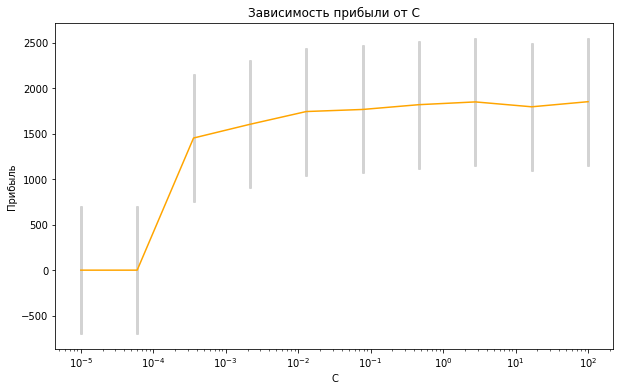

In [190]:
plt.figure(figsize=(10, 6))
plt.errorbar(C_all, list_mn, yerr=np.std(list_mn), fmt='-', color='orange',
             ecolor='lightgray', elinewidth=3, capsize=1)
plt.title('Зависимость прибыли от C')
plt.xlabel('C')
plt.ylabel('Прибыль')
plt.xscale('log')
plt.show()

In [188]:
profit_base = 2141.44893000345 - 324.2
profit

1897.4354066658548

Выигрыш не получился, так как 1863.5754699555 < 1897.4354066658548 (это наша прибыль в первом случае)

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Запуск 1:
C = 2.782559402207126
Прибыль = 1847.7672556164762



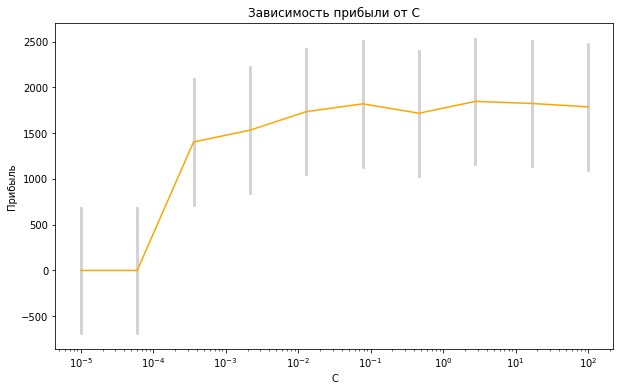

Запуск 2:
C = 16.68100537200059
Прибыль = 1873.6089740248233



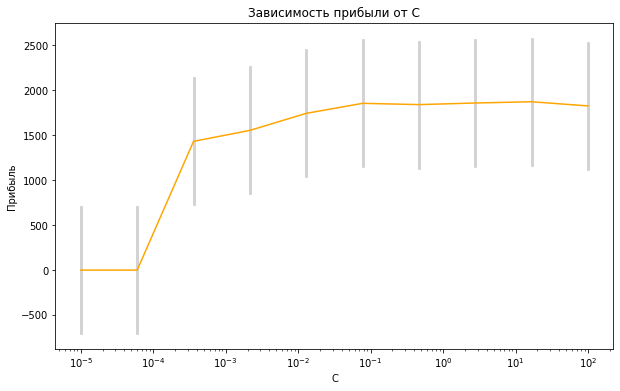

Запуск 3:
C = 100.0
Прибыль = 1854.9739181471407



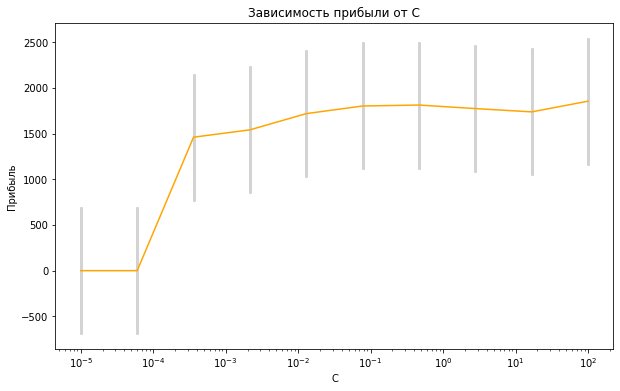

Запуск 4:
C = 16.68100537200059
Прибыль = 1847.5826065420108



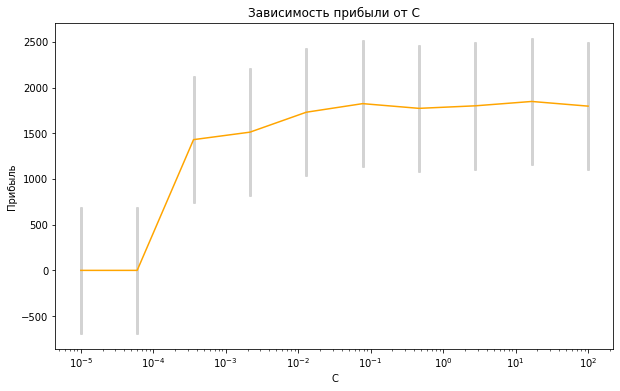

Запуск 5:
C = 100.0
Прибыль = 1871.6407795230741



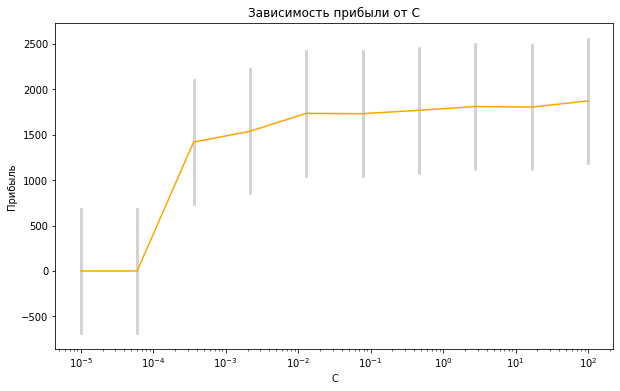

Запуск 6:
C = 0.4641588833612782
Прибыль = 1854.5617373304897



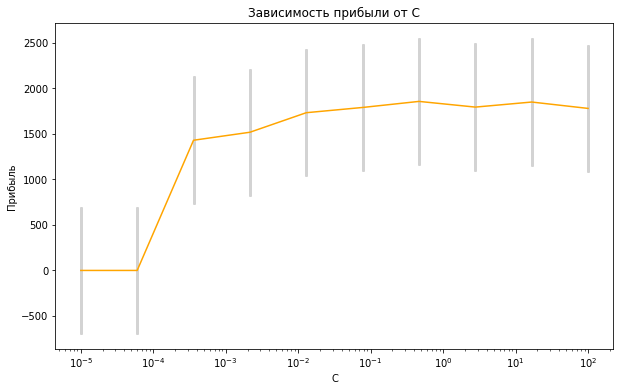

Запуск 7:
C = 2.782559402207126
Прибыль = 1820.19650470197



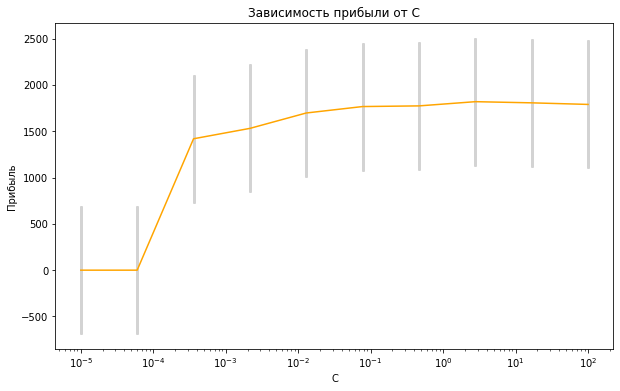

Запуск 8:
C = 2.782559402207126
Прибыль = 1923.2842517352972



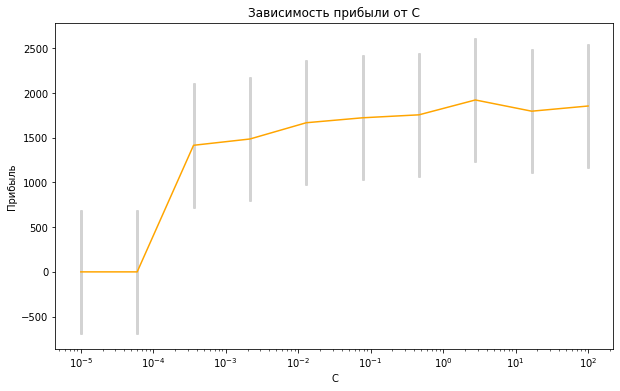

Запуск 9:
C = 100.0
Прибыль = 1819.6516881701646



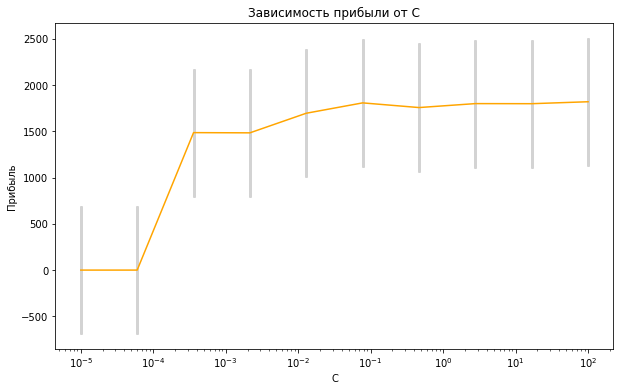

Запуск 10:
C = 16.68100537200059
Прибыль = 1820.4978321995054



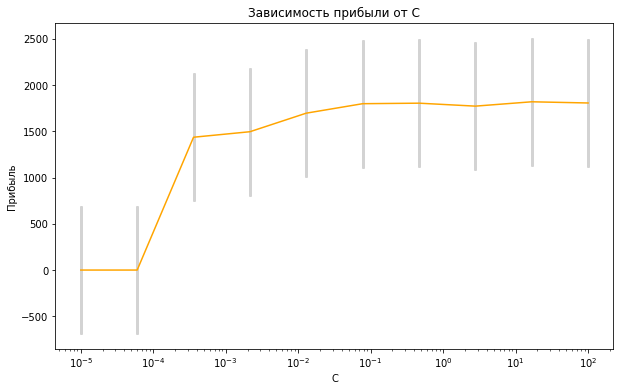

In [192]:
C_all = np.logspace(-5, 2, 10)

for i in range(10):
    best_c = -100
    profit = -100
    list_mn = []
    for C in C_all:
        list_profit = []

        for train_ind, test_ind in kf.split(X):
            X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
            y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
            X_train = column_transformer.fit_transform(X_train)
            X_test = column_transformer.transform(X_test)
            lr = LogisticRegression(max_iter=100000, C = C).fit(X_train, y_train)
            y_pred_lr = lr.predict(X_test)


            positive = sum(y_test[y_pred_lr == True] * np.random.uniform(0,20, size = y_test[y_pred_lr == True].shape[0]))
            to_worker = sum(y_pred_lr)
            list_profit.append(positive - to_worker)

        mn_prof = np.mean(list_profit)
        list_mn.append(np.mean(list_profit))
        if mn_prof > profit:
            profit = mn_prof
            best_c = C
            
        
    print(f"Запуск {i+1}:")
    print(f'C = {best_c}')
    print(f'Прибыль = {profit}\n')
    plt.figure(figsize=(10, 6))
    plt.errorbar(C_all, list_mn, yerr=np.std(list_mn), fmt='-', color='orange',
                 ecolor='lightgray', elinewidth=3, capsize=1)
    plt.title('Зависимость прибыли от C')
    plt.xlabel('C')
    plt.ylabel('Прибыль')
    plt.xscale('log')
    plt.show()
    
    

Есть небольшая зависимость в том, что когда C доходит до 10^(-3), то дальше наблюдается рост прибыли с увеличением C не такой сильный, как до этого значения. Не всегда одно и то же лучшее значение С получается. 

Лучший профит получили при C = 2.782559402207126 (Прибыль = 1923.2842517352972). Но тут конечно же рандом присутсвует, так как не знаем сколько точно принесет нам один клиент

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Думаю важнее recall, так как нам лучше звонить тому, в ком мы лучше уверены. А recall показывает какую долю из всех, кто возьмет дипозит мы предсказали верно 



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [209]:
best_threshold = -1
profit = -100
all_threshold = np.arange(0, 1, 0.01)
list_mn = []
for threshold in tqdm(all_threshold):
    list_profit = []
    for train_ind, test_ind in kf.split(X):
            X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
            y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
            X_train = column_transformer.fit_transform(X_train)
            X_test = column_transformer.transform(X_test)
            lr = LogisticRegression(max_iter=100000, C = 2.782559402207126).fit(X_train, y_train)
            y_pred_lr = lr.predict_proba(X_test)[:, 1]
            y_pred_lr = y_pred_lr >= threshold



            positive = sum(y_test[y_pred_lr == True] * np.random.uniform(0,20, size = y_test[y_pred_lr == True].shape[0]))
            to_worker = sum(y_pred_lr)
            list_profit.append(positive - to_worker)

    mn_prof = np.mean(list_profit)
    list_mn.append(np.mean(list_profit))
    if mn_prof > profit:
        profit = mn_prof
        best_threshold = threshold
        
        
print(f'Лучший порог = {best_threshold}')
print(f'Прибыль = {profit}')

100%|██████████| 100/100 [08:45<00:00,  5.26s/it]

Лучший порог = 0.11
Прибыль = 4339.518942752361


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




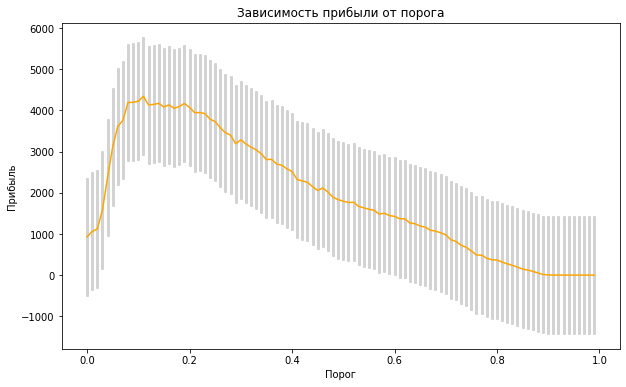

In [210]:
plt.figure(figsize=(10, 6))
plt.errorbar(all_threshold, list_mn, yerr=np.std(list_mn), fmt='-', color='orange',
             ecolor='lightgray', elinewidth=3, capsize=1)
plt.title('Зависимость прибыли от порога')
plt.xlabel('Порог')
plt.ylabel('Прибыль')
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Запускал несколько раз, порог в диапазоне 0.1 - 0.13. Это как раз-таки сходиться с моим предположением, что нам важнее recall. Лучший порог получился 0.11 (best_threshold)

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [215]:
from sklearn.metrics import precision_score, recall_score

list_profit = []
precision = []
recall = []
for train_ind, test_ind in kf.split(X):
        X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
        X_train = column_transformer.fit_transform(X_train)
        X_test = column_transformer.transform(X_test)
        
        lr = LogisticRegression(max_iter=100000, C = 2.782559402207126).fit(X_train, y_train)
        y_pred_lr = lr.predict_proba(X_test)[:, 1]
        y_pred_lr = y_pred_lr >= best_threshold
        
        precision.append(precision_score(y_test, y_pred_lr))
        recall.append(recall_score(y_test, y_pred_lr))

print(f"Средний precision: {np.mean(precision)}\nstd precision: {np.std(precision)}\n")
print(f"Средний recall: {np.mean(recall)}\nstd recall: {np.std(recall)}")

Средний precision: 0.3372519641154056
std precision: 0.012390415739275027

Средний recall: 0.6420518700077229
std recall: 0.02078450221130864


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [223]:
all_threshold = np.arange(0, 1, 0.01)
prec_mn = []
rec_mn = []
for threshold in tqdm(all_threshold):
    precision = []
    recall = []
    for train_ind, test_ind in kf.split(X):
            X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
            y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
            X_train = column_transformer.fit_transform(X_train)
            X_test = column_transformer.transform(X_test)

            lr = LogisticRegression(max_iter=100000, C = 2.782559402207126).fit(X_train, y_train)
            y_pred_lr = lr.predict_proba(X_test)[:, 1]
            y_pred_lr = y_pred_lr >= threshold

            precision.append(precision_score(y_test, y_pred_lr))
            recall.append(recall_score(y_test, y_pred_lr))
    
    mean_recall = np.mean(recall)
    prec_mn.append(np.mean(precision))
    rec_mn.append(mean_recall)
    if mean_recall < 0.5:
        break
        
prec_mn = np.array(prec_mn) 
rec_mn = np.array(rec_mn) 

ans_prec = (prec_mn - np.min(prec_mn)) / (np.max(prec_mn) - np.min(prec_mn))
ans_rec = (rec_mn - np.min(rec_mn)) / (np.max(rec_mn) - np.min(rec_mn))
answer = auc(ans_rec, ans_prec)

print(f"PR-AUC:{answer}")

 25%|██▌       | 25/100 [02:22<07:07,  5.69s/it]

PR-AUC:0.4101762639479671


__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Кофеечек с сырничками, а еще sour gummy worms (хорошая кстати)